In [ ]:
# %%

# Use Google Colab
use_google_colab = False
# Process the training dataset
training_data_processing = False
# Train the model
model_training = True
# Validation the model
model_validation = True
# Load the model from your Google Drive or local file system
model_loading = False

import numpy as np
import torch

from util.cuda import cuda
from util.gpu_info import gpuInfo
from util.data_augmentation import training_data_loading, training_data_augmentation
from util.loss import BCEIoULoss
from util.training import train
from util.testing import submission_creating, test

from networks.LinkNetB7 import *
from networks.DLinkNet34 import *
from networks.DLinkNet50 import *
from networks.DLinkNet101 import *
from networks.LinkNet34 import *
from networks.UNet import *


path_training = "./training/"
path_testing = "./test/"
path_data = "./data/"
path_model = "./models/LinkNetB7.model"

cuda_available = torch.cuda.is_available()
if cuda_available:
    print("CUDA is available. Utilize GPUs for computation")
    device = torch.device("cuda")
else:
    print("CUDA is not available. Utilize CPUs for computation.")
    device = torch.device("cpu")

gpu_info = gpuInfo()

model = LinkNetB7()

if cuda_available:
    model.cuda()
print(model)

CUDA is available. Utilize GPUs for computation
Thu Nov  7 10:19:50 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4080        Off |   00000000:01:00.0  On |                  N/A |
|  0%   40C    P8             18W /  340W |     439MiB /  16376MiB |     19%      Default |
|                                         |                        |                  N/A |


/home/wesley/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/wesley/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


LinkNetB7(
  (input_block): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (encoder1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(64, 32, kernel_size=(1, 1), strid

In [ ]:
# %%

# The resolution of resized training images and the corresponding masks
training_resize = 512
# The number of resized training pairs used for data augmentation
training_number = 367
# The resolution of resized testing images
testing_resize = int(608 * training_resize / 400)
if testing_resize % 2 == 1:
    testing_resize += 1

if training_data_processing:
    # Load and generate the resized training dataset and validation dataset
    images_training, labels_training, images_validation, labels_validation = (
        training_data_loading(path_training, training_resize, training_number)
    )
    # Generate the augmented training dataset
    rotations = [0, 45, 90, 135]  # the rotation angle

    flips = ["original", np.flipud, np.fliplr]  # 'original', np.flipud, np.fliplr

    shifts = [(-16, 16)]

    images_augmented, labels_augmented = training_data_augmentation(
        images_training, labels_training, rotations, flips, shifts, training_resize
    )
    # Save the augmented training dataset and resized validation dataset
    # to your Google Drive or local file system
    np.save(f"{path_data}images_training", images_augmented)
    np.save(f"{path_data}labels_training", labels_augmented)
    np.save(f"{path_data}images_validation", images_validation)
    np.save(f"{path_data}labels_validation", labels_validation)
elif not model_loading:
    # Load the augmented training dataset and resized validation dataset
    # from your Google Drive or local file system
    images_augmented = np.load(f"{path_data}images_training.npy")
    labels_augmented = np.load(f"{path_data}labels_training.npy")
    images_validation = np.load(f"{path_data}images_validation.npy")
    labels_validation = np.load(f"{path_data}labels_validation.npy")

if model_training:
    print(f"\nimages_training.shape = {images_augmented.shape}")
    print(f"labels_training.shape = {labels_augmented.shape}")
    print(f"images_validation.shape = {images_validation.shape}")
    print(f"labels_validation.shape = {labels_validation.shape}")


images_training.shape = (6264, 3, 512, 512)
labels_training.shape = (6264, 1, 512, 512)
images_validation.shape = (224, 3, 512, 512)
labels_validation.shape = (224, 1, 512, 512)


/home/wesley/miniconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
  0%|          | 0/20 [00:00<?, ?it/s]


---------Training for Epoch 1 starting:---------
→ Running_loss for Batch 1: 0.39789026975631714
→ ACC for Batch 1: 0.040421485900878906
→ Running_loss for Batch 21: 0.3910644054412842
→ ACC for Batch 21: 0.9745826721191406
→ Running_loss for Batch 41: 0.3858717679977417
→ ACC for Batch 41: 0.9818992614746094
→ Running_loss for Batch 61: 0.3336230218410492
→ ACC for Batch 61: 0.9756803512573242
→ Running_loss for Batch 81: 0.2540816366672516
→ ACC for Batch 81: 0.9556903839111328
→ Running_loss for Batch 101: 0.27701231837272644
→ ACC for Batch 101: 0.9626398086547852
→ Running_loss for Batch 121: 0.25760552287101746
→ ACC for Batch 121: 0.9675922393798828
→ Running_loss for Batch 141: 0.23848563432693481
→ ACC for Batch 141: 0.9707231521606445
→ Running_loss for Batch 161: 0.23471491038799286
→ ACC for Batch 161: 0.9694948196411133
→ Running_loss for Batch 181: 0.27012696862220764
→ ACC for Batch 181: 0.9711179733276367
→ Running_loss for Batch 201: 0.1956494301557541
→ ACC for Batch

  5%|▌         | 1/20 [14:53<4:42:47, 893.04s/it]


---------Training for Epoch 2 starting:---------
→ Running_loss for Batch 1: 0.13838638365268707
→ ACC for Batch 1: 0.9917736053466797
→ Running_loss for Batch 21: 0.14185354113578796
→ ACC for Batch 21: 0.9894790649414062
→ Running_loss for Batch 41: 0.16871289908885956
→ ACC for Batch 41: 0.9869222640991211
→ Running_loss for Batch 61: 0.1600300818681717
→ ACC for Batch 61: 0.9922914505004883
→ Running_loss for Batch 81: 0.134308859705925
→ ACC for Batch 81: 0.9852638244628906
→ Running_loss for Batch 101: 0.12849612534046173
→ ACC for Batch 101: 0.994166374206543
→ Running_loss for Batch 121: 0.16952632367610931
→ ACC for Batch 121: 0.9762735366821289
→ Running_loss for Batch 141: 0.1439206898212433
→ ACC for Batch 141: 0.9843530654907227
→ Running_loss for Batch 161: 0.14795084297657013
→ ACC for Batch 161: 0.9863758087158203
→ Running_loss for Batch 181: 0.10860057920217514
→ ACC for Batch 181: 0.9914951324462891
→ Running_loss for Batch 201: 0.1147797629237175
→ ACC for Batch 20

 10%|█         | 2/20 [23:21<3:20:06, 667.05s/it]


---------Training for Epoch 3 starting:---------
→ Running_loss for Batch 1: 0.09768316149711609
→ ACC for Batch 1: 0.992009162902832
→ Running_loss for Batch 21: 0.08615516871213913
→ ACC for Batch 21: 0.995854377746582
→ Running_loss for Batch 41: 0.1128322035074234
→ ACC for Batch 41: 0.9901514053344727
→ Running_loss for Batch 61: 0.1515856385231018
→ ACC for Batch 61: 0.9952535629272461
→ Running_loss for Batch 81: 0.09127116948366165
→ ACC for Batch 81: 0.9904994964599609
→ Running_loss for Batch 101: 0.12421736866235733
→ ACC for Batch 101: 0.9880123138427734
→ Running_loss for Batch 121: 0.11491941660642624
→ ACC for Batch 121: 0.9876766204833984
→ Running_loss for Batch 141: 0.13008616864681244
→ ACC for Batch 141: 0.9906139373779297
→ Running_loss for Batch 161: 0.1372956484556198
→ ACC for Batch 161: 0.9852924346923828
→ Running_loss for Batch 181: 0.11457234621047974
→ ACC for Batch 181: 0.9928255081176758
→ Running_loss for Batch 201: 0.12472011893987656
→ ACC for Batch 2

 15%|█▌        | 3/20 [32:01<2:49:51, 599.52s/it]


---------Training for Epoch 4 starting:---------
→ Running_loss for Batch 1: 0.10277284681797028
→ ACC for Batch 1: 0.9874553680419922
→ Running_loss for Batch 21: 0.10755806416273117
→ ACC for Batch 21: 0.985809326171875
→ Running_loss for Batch 41: 0.09779590368270874
→ ACC for Batch 41: 0.9846706390380859
→ Running_loss for Batch 61: 0.09832774847745895
→ ACC for Batch 61: 0.9916629791259766
→ Running_loss for Batch 81: 0.1230471208691597
→ ACC for Batch 81: 0.9859676361083984
→ Running_loss for Batch 101: 0.09755174815654755
→ ACC for Batch 101: 0.9833126068115234
→ Running_loss for Batch 121: 0.10936500877141953
→ ACC for Batch 121: 0.9816913604736328
→ Running_loss for Batch 141: 0.12098594754934311
→ ACC for Batch 141: 0.9873971939086914
→ Running_loss for Batch 161: 0.10682398080825806
→ ACC for Batch 161: 0.9912214279174805
→ Running_loss for Batch 181: 0.09584259241819382
→ ACC for Batch 181: 0.9945707321166992
→ Running_loss for Batch 201: 0.08280391991138458
→ ACC for Batc

 20%|██        | 4/20 [40:46<2:32:04, 570.27s/it]


---------Training for Epoch 5 starting:---------
→ Running_loss for Batch 1: 0.0930410698056221
→ ACC for Batch 1: 0.996638298034668
→ Running_loss for Batch 21: 0.11885949224233627
→ ACC for Batch 21: 0.9919261932373047
→ Running_loss for Batch 41: 0.08879941701889038
→ ACC for Batch 41: 0.9924430847167969
→ Running_loss for Batch 61: 0.11421533674001694
→ ACC for Batch 61: 0.9942073822021484
→ Running_loss for Batch 81: 0.12599213421344757
→ ACC for Batch 81: 0.9941549301147461
→ Running_loss for Batch 101: 0.10524076223373413
→ ACC for Batch 101: 0.9906949996948242
→ Running_loss for Batch 121: 0.0890912190079689
→ ACC for Batch 121: 0.9945535659790039
→ Running_loss for Batch 141: 0.0763072669506073
→ ACC for Batch 141: 0.995701789855957
→ Running_loss for Batch 161: 0.1002422422170639
→ ACC for Batch 161: 0.991424560546875
→ Running_loss for Batch 181: 0.08627010881900787
→ ACC for Batch 181: 0.9910163879394531
→ Running_loss for Batch 201: 0.11528573930263519
→ ACC for Batch 201

 25%|██▌       | 5/20 [49:25<2:17:58, 551.92s/it]


---------Training for Epoch 6 starting:---------
→ Running_loss for Batch 1: 0.11446528136730194
→ ACC for Batch 1: 0.9973573684692383
→ Running_loss for Batch 21: 0.09486041218042374
→ ACC for Batch 21: 0.9960536956787109
→ Running_loss for Batch 41: 0.08458476513624191
→ ACC for Batch 41: 0.9883499145507812
→ Running_loss for Batch 61: 0.12049801647663116
→ ACC for Batch 61: 0.9877490997314453
→ Running_loss for Batch 81: 0.09902118146419525
→ ACC for Batch 81: 0.9940719604492188
→ Running_loss for Batch 101: 0.0871758684515953
→ ACC for Batch 101: 0.9879217147827148
→ Running_loss for Batch 121: 0.11354368925094604
→ ACC for Batch 121: 0.9928455352783203
→ Running_loss for Batch 141: 0.1183452308177948
→ ACC for Batch 141: 0.9965829849243164
→ Running_loss for Batch 161: 0.09864973276853561
→ ACC for Batch 161: 0.9962186813354492
→ Running_loss for Batch 181: 0.08676016330718994
→ ACC for Batch 181: 0.9950523376464844
→ Running_loss for Batch 201: 0.10869980603456497
→ ACC for Batc

 30%|███       | 6/20 [58:06<2:06:19, 541.40s/it]


---------Training for Epoch 7 starting:---------
→ Running_loss for Batch 1: 0.07776433229446411
→ ACC for Batch 1: 0.9927406311035156
→ Running_loss for Batch 21: 0.07407726347446442
→ ACC for Batch 21: 0.991847038269043
→ Running_loss for Batch 41: 0.08547555655241013
→ ACC for Batch 41: 0.9923467636108398
→ Running_loss for Batch 61: 0.12622050940990448
→ ACC for Batch 61: 0.9987201690673828
→ Running_loss for Batch 81: 0.07918491959571838
→ ACC for Batch 81: 0.9954109191894531
→ Running_loss for Batch 101: 0.08490754663944244
→ ACC for Batch 101: 0.9857063293457031
→ Running_loss for Batch 121: 0.07392097264528275
→ ACC for Batch 121: 0.9913043975830078
→ Running_loss for Batch 141: 0.12797720730304718
→ ACC for Batch 141: 0.9899282455444336
→ Running_loss for Batch 161: 0.08616545796394348
→ ACC for Batch 161: 0.9931488037109375
→ Running_loss for Batch 181: 0.10045378655195236
→ ACC for Batch 181: 0.98565673828125
→ Running_loss for Batch 201: 0.08047620952129364
→ ACC for Batch

 35%|███▌      | 7/20 [1:06:34<1:54:56, 530.53s/it]


---------Training for Epoch 8 starting:---------
→ Running_loss for Batch 1: 0.07457361370325089
→ ACC for Batch 1: 0.9927005767822266
→ Running_loss for Batch 21: 0.08965551853179932
→ ACC for Batch 21: 0.9950313568115234
→ Running_loss for Batch 41: 0.06767917424440384
→ ACC for Batch 41: 0.9940605163574219
→ Running_loss for Batch 61: 0.0947548970580101
→ ACC for Batch 61: 0.9903059005737305
→ Running_loss for Batch 81: 0.07730625569820404
→ ACC for Batch 81: 0.9930391311645508
→ Running_loss for Batch 101: 0.09934292733669281
→ ACC for Batch 101: 0.9898309707641602
→ Running_loss for Batch 121: 0.10922057181596756
→ ACC for Batch 121: 0.9923000335693359
→ Running_loss for Batch 141: 0.08206306397914886
→ ACC for Batch 141: 0.9941139221191406
→ Running_loss for Batch 161: 0.0839775875210762
→ ACC for Batch 161: 0.9912347793579102
→ Running_loss for Batch 181: 0.09030592441558838
→ ACC for Batch 181: 0.9956979751586914
→ Running_loss for Batch 201: 0.10134541988372803
→ ACC for Batc

 40%|████      | 8/20 [1:15:05<1:44:49, 524.16s/it]


---------Training for Epoch 9 starting:---------
→ Running_loss for Batch 1: 0.08017481863498688
→ ACC for Batch 1: 0.9945755004882812
→ Running_loss for Batch 21: 0.09280262887477875
→ ACC for Batch 21: 0.9926319122314453
→ Running_loss for Batch 41: 0.10619000345468521
→ ACC for Batch 41: 0.9963779449462891
→ Running_loss for Batch 61: 0.08353004604578018
→ ACC for Batch 61: 0.9943094253540039
→ Running_loss for Batch 81: 0.10956855118274689
→ ACC for Batch 81: 0.9956798553466797
→ Running_loss for Batch 101: 0.10069096833467484
→ ACC for Batch 101: 0.9931564331054688
→ Running_loss for Batch 121: 0.07992293685674667
→ ACC for Batch 121: 0.9881153106689453
→ Running_loss for Batch 141: 0.08634956181049347
→ ACC for Batch 141: 0.9949474334716797
→ Running_loss for Batch 161: 0.06583419442176819
→ ACC for Batch 161: 0.9942836761474609
→ Running_loss for Batch 181: 0.09678962826728821
→ ACC for Batch 181: 0.9870510101318359
→ Running_loss for Batch 201: 0.10424686968326569
→ ACC for Ba

 45%|████▌     | 9/20 [1:23:18<1:34:18, 514.43s/it]


---------Training for Epoch 10 starting:---------
→ Running_loss for Batch 1: 0.07667616009712219
→ ACC for Batch 1: 0.9892597198486328
→ Running_loss for Batch 21: 0.07583080977201462
→ ACC for Batch 21: 0.9933967590332031
→ Running_loss for Batch 41: 0.06410504132509232
→ ACC for Batch 41: 0.9931011199951172
→ Running_loss for Batch 61: 0.08454637974500656
→ ACC for Batch 61: 0.9925727844238281
→ Running_loss for Batch 81: 0.0756101980805397
→ ACC for Batch 81: 0.993377685546875
→ Running_loss for Batch 101: 0.06259939819574356
→ ACC for Batch 101: 0.9948701858520508
→ Running_loss for Batch 121: 0.09462602436542511
→ ACC for Batch 121: 0.9916620254516602
→ Running_loss for Batch 141: 0.06543245911598206
→ ACC for Batch 141: 0.9921998977661133
→ Running_loss for Batch 161: 0.07833613455295563
→ ACC for Batch 161: 0.9882802963256836
→ Running_loss for Batch 181: 0.08443743735551834
→ ACC for Batch 181: 0.9913082122802734
→ Running_loss for Batch 201: 0.07319018989801407
→ ACC for Bat

 50%|█████     | 10/20 [1:31:21<1:24:06, 504.64s/it]


---------Training for Epoch 11 starting:---------
→ Running_loss for Batch 1: 0.0824764296412468
→ ACC for Batch 1: 0.9891176223754883
→ Running_loss for Batch 21: 0.07952422648668289
→ ACC for Batch 21: 0.9947786331176758
→ Running_loss for Batch 41: 0.08109398931264877
→ ACC for Batch 41: 0.9953079223632812
→ Running_loss for Batch 61: 0.07176242023706436
→ ACC for Batch 61: 0.9957494735717773
→ Running_loss for Batch 81: 0.09846571832895279
→ ACC for Batch 81: 0.9954748153686523
→ Running_loss for Batch 101: 0.06856678426265717
→ ACC for Batch 101: 0.9954004287719727
→ Running_loss for Batch 121: 0.06533905863761902
→ ACC for Batch 121: 0.9941587448120117
→ Running_loss for Batch 141: 0.06667239218950272
→ ACC for Batch 141: 0.9961147308349609
→ Running_loss for Batch 161: 0.0580226331949234
→ ACC for Batch 161: 0.9960041046142578
→ Running_loss for Batch 181: 0.07973599433898926
→ ACC for Batch 181: 0.9908390045166016
→ Running_loss for Batch 201: 0.08305446803569794
→ ACC for Bat

 55%|█████▌    | 11/20 [1:39:36<1:15:16, 501.82s/it]


---------Training for Epoch 12 starting:---------
→ Running_loss for Batch 1: 0.0797397717833519
→ ACC for Batch 1: 0.992919921875
→ Running_loss for Batch 21: 0.0637042298913002
→ ACC for Batch 21: 0.9937591552734375
→ Running_loss for Batch 41: 0.07444194704294205
→ ACC for Batch 41: 0.9942808151245117
→ Running_loss for Batch 61: 0.08258132636547089
→ ACC for Batch 61: 0.9956455230712891
→ Running_loss for Batch 81: 0.06037791445851326
→ ACC for Batch 81: 0.9946527481079102
→ Running_loss for Batch 101: 0.09366892278194427
→ ACC for Batch 101: 0.9939174652099609
→ Running_loss for Batch 121: 0.07158877700567245
→ ACC for Batch 121: 0.9950742721557617
→ Running_loss for Batch 141: 0.088884636759758
→ ACC for Batch 141: 0.9982442855834961
→ Running_loss for Batch 161: 0.057096756994724274
→ ACC for Batch 161: 0.9961719512939453
→ Running_loss for Batch 181: 0.0726567953824997
→ ACC for Batch 181: 0.9953432083129883
→ Running_loss for Batch 201: 0.07521453499794006
→ ACC for Batch 201

 60%|██████    | 12/20 [1:47:48<1:06:29, 498.70s/it]


---------Training for Epoch 13 starting:---------
→ Running_loss for Batch 1: 0.06841456145048141
→ ACC for Batch 1: 0.9946784973144531
→ Running_loss for Batch 21: 0.06640994548797607
→ ACC for Batch 21: 0.9929122924804688
→ Running_loss for Batch 41: 0.08173749595880508
→ ACC for Batch 41: 0.9949064254760742
→ Running_loss for Batch 61: 0.08556066453456879
→ ACC for Batch 61: 0.9866228103637695
→ Running_loss for Batch 81: 0.08018393069505692
→ ACC for Batch 81: 0.9931554794311523
→ Running_loss for Batch 101: 0.07877755910158157
→ ACC for Batch 101: 0.994877815246582
→ Running_loss for Batch 121: 0.05911203473806381
→ ACC for Batch 121: 0.9953756332397461
→ Running_loss for Batch 141: 0.07544539868831635
→ ACC for Batch 141: 0.9956541061401367
→ Running_loss for Batch 161: 0.08162489533424377
→ ACC for Batch 161: 0.9929141998291016
→ Running_loss for Batch 181: 0.0712423324584961
→ ACC for Batch 181: 0.9958105087280273
→ Running_loss for Batch 201: 0.054981205612421036
→ ACC for Ba

 65%|██████▌   | 13/20 [1:56:23<58:45, 503.65s/it]  


---------Training for Epoch 14 starting:---------
→ Running_loss for Batch 1: 0.08984959870576859
→ ACC for Batch 1: 0.9925737380981445
→ Running_loss for Batch 21: 0.07614036649465561
→ ACC for Batch 21: 0.9958963394165039
→ Running_loss for Batch 41: 0.0792446881532669
→ ACC for Batch 41: 0.9941425323486328
→ Running_loss for Batch 61: 0.084479421377182
→ ACC for Batch 61: 0.9971227645874023
→ Running_loss for Batch 81: 0.08787130564451218
→ ACC for Batch 81: 0.9983482360839844
→ Running_loss for Batch 101: 0.07687150686979294
→ ACC for Batch 101: 0.99639892578125
→ Running_loss for Batch 121: 0.08263155817985535
→ ACC for Batch 121: 0.9915046691894531
→ Running_loss for Batch 141: 0.05847443267703056
→ ACC for Batch 141: 0.9961910247802734
→ Running_loss for Batch 161: 0.05427471175789833
→ ACC for Batch 161: 0.9965362548828125
→ Running_loss for Batch 181: 0.0732949823141098
→ ACC for Batch 181: 0.9938316345214844
→ Running_loss for Batch 201: 0.06636043637990952
→ ACC for Batch 2

 70%|███████   | 14/20 [2:04:48<50:24, 504.09s/it]


---------Training for Epoch 15 starting:---------
→ Running_loss for Batch 1: 0.08653485774993896
→ ACC for Batch 1: 0.9883260726928711
→ Running_loss for Batch 21: 0.07134387642145157
→ ACC for Batch 21: 0.9937896728515625
→ Running_loss for Batch 41: 0.07267633825540543
→ ACC for Batch 41: 0.9975309371948242
→ Running_loss for Batch 61: 0.09343501180410385
→ ACC for Batch 61: 0.992924690246582
→ Running_loss for Batch 81: 0.0578538216650486
→ ACC for Batch 81: 0.9955224990844727
→ Running_loss for Batch 101: 0.07610272616147995
→ ACC for Batch 101: 0.9966831207275391
→ Running_loss for Batch 121: 0.05239972099661827
→ ACC for Batch 121: 0.995305061340332
→ Running_loss for Batch 141: 0.08647671341896057
→ ACC for Batch 141: 0.9914159774780273
→ Running_loss for Batch 161: 0.07505471259355545
→ ACC for Batch 161: 0.9910335540771484
→ Running_loss for Batch 181: 0.08146922290325165
→ ACC for Batch 181: 0.9933662414550781
→ Running_loss for Batch 201: 0.089474156498909
→ ACC for Batch 

 75%|███████▌  | 15/20 [2:13:34<42:33, 510.77s/it]


---------Training for Epoch 16 starting:---------
→ Running_loss for Batch 1: 0.08629966527223587
→ ACC for Batch 1: 0.995997428894043
→ Running_loss for Batch 21: 0.06212511658668518
→ ACC for Batch 21: 0.9945974349975586
→ Running_loss for Batch 41: 0.09174137562513351
→ ACC for Batch 41: 0.9971437454223633
→ Running_loss for Batch 61: 0.05976323038339615
→ ACC for Batch 61: 0.9940328598022461
→ Running_loss for Batch 81: 0.07567872852087021
→ ACC for Batch 81: 0.9962968826293945
→ Running_loss for Batch 101: 0.05461042746901512
→ ACC for Batch 101: 0.9960260391235352
→ Running_loss for Batch 121: 0.07011185586452484
→ ACC for Batch 121: 0.9955463409423828
→ Running_loss for Batch 141: 0.05260515958070755
→ ACC for Batch 141: 0.9964694976806641
→ Running_loss for Batch 161: 0.07048923522233963
→ ACC for Batch 161: 0.990321159362793
→ Running_loss for Batch 181: 0.061710841953754425
→ ACC for Batch 181: 0.9948301315307617
→ Running_loss for Batch 201: 0.08928795158863068
→ ACC for Ba

 80%|████████  | 16/20 [2:21:56<33:52, 508.05s/it]


---------Training for Epoch 17 starting:---------
→ Running_loss for Batch 1: 0.05712937191128731
→ ACC for Batch 1: 0.9961404800415039
→ Running_loss for Batch 21: 0.07807457447052002
→ ACC for Batch 21: 0.9975481033325195
→ Running_loss for Batch 41: 0.06243899092078209
→ ACC for Batch 41: 0.9939727783203125
→ Running_loss for Batch 61: 0.05905245989561081
→ ACC for Batch 61: 0.9945383071899414
→ Running_loss for Batch 81: 0.05235954001545906
→ ACC for Batch 81: 0.9959402084350586
→ Running_loss for Batch 101: 0.07472191005945206
→ ACC for Batch 101: 0.9955921173095703
→ Running_loss for Batch 121: 0.05261307209730148
→ ACC for Batch 121: 0.9958906173706055
→ Running_loss for Batch 141: 0.0813152864575386
→ ACC for Batch 141: 0.9969711303710938
→ Running_loss for Batch 161: 0.06903040409088135
→ ACC for Batch 161: 0.9921417236328125
→ Running_loss for Batch 181: 0.05822460353374481
→ ACC for Batch 181: 0.9976835250854492
→ Running_loss for Batch 201: 0.06495723873376846
→ ACC for Ba

 85%|████████▌ | 17/20 [2:30:52<25:49, 516.50s/it]


---------Training for Epoch 18 starting:---------
→ Running_loss for Batch 1: 0.07405592501163483
→ ACC for Batch 1: 0.9925451278686523
→ Running_loss for Batch 21: 0.06826557219028473
→ ACC for Batch 21: 0.9945459365844727
→ Running_loss for Batch 41: 0.06512495130300522
→ ACC for Batch 41: 0.9956436157226562
→ Running_loss for Batch 61: 0.07499919831752777
→ ACC for Batch 61: 0.9961786270141602
→ Running_loss for Batch 81: 0.06882449239492416
→ ACC for Batch 81: 0.9952192306518555
→ Running_loss for Batch 101: 0.07766807824373245
→ ACC for Batch 101: 0.9946889877319336
→ Running_loss for Batch 121: 0.060084160417318344
→ ACC for Batch 121: 0.9962224960327148
→ Running_loss for Batch 141: 0.07624392211437225
→ ACC for Batch 141: 0.9949483871459961
→ Running_loss for Batch 161: 0.07714596390724182
→ ACC for Batch 161: 0.996190071105957
→ Running_loss for Batch 181: 0.06361989676952362
→ ACC for Batch 181: 0.9952058792114258
→ Running_loss for Batch 201: 0.05979246646165848
→ ACC for B

 90%|█████████ | 18/20 [2:40:48<18:00, 540.40s/it]


---------Training for Epoch 19 starting:---------
→ Running_loss for Batch 1: 0.06648103892803192
→ ACC for Batch 1: 0.9918317794799805
→ Running_loss for Batch 21: 0.06389038264751434
→ ACC for Batch 21: 0.9972543716430664
→ Running_loss for Batch 41: 0.05738993361592293
→ ACC for Batch 41: 0.9963197708129883
→ Running_loss for Batch 61: 0.05510757863521576
→ ACC for Batch 61: 0.9929904937744141
→ Running_loss for Batch 81: 0.05457307770848274
→ ACC for Batch 81: 0.9961061477661133
→ Running_loss for Batch 101: 0.07573562115430832
→ ACC for Batch 101: 0.9920921325683594
→ Running_loss for Batch 121: 0.08101240545511246
→ ACC for Batch 121: 0.9933233261108398
→ Running_loss for Batch 141: 0.06434747576713562
→ ACC for Batch 141: 0.9906187057495117
→ Running_loss for Batch 161: 0.050249695777893066
→ ACC for Batch 161: 0.9957923889160156
→ Running_loss for Batch 181: 0.06409601867198944
→ ACC for Batch 181: 0.9953603744506836
→ Running_loss for Batch 201: 0.054996296763420105
→ ACC for

 95%|█████████▌| 19/20 [2:50:27<09:12, 552.04s/it]


---------Training for Epoch 20 starting:---------
→ Running_loss for Batch 1: 0.07907956838607788
→ ACC for Batch 1: 0.9950799942016602
→ Running_loss for Batch 21: 0.05677931383252144
→ ACC for Batch 21: 0.9929952621459961
→ Running_loss for Batch 41: 0.0518936924636364
→ ACC for Batch 41: 0.995208740234375
→ Running_loss for Batch 61: 0.05957596004009247
→ ACC for Batch 61: 0.9965810775756836
→ Running_loss for Batch 81: 0.061374127864837646
→ ACC for Batch 81: 0.9967050552368164
→ Running_loss for Batch 101: 0.048538412898778915
→ ACC for Batch 101: 0.9966440200805664
→ Running_loss for Batch 121: 0.07205941528081894
→ ACC for Batch 121: 0.9934120178222656
→ Running_loss for Batch 141: 0.07096920162439346
→ ACC for Batch 141: 0.9941873550415039
→ Running_loss for Batch 161: 0.07188483327627182
→ ACC for Batch 161: 0.9912586212158203
→ Running_loss for Batch 181: 0.06050465628504753
→ ACC for Batch 181: 0.9940929412841797
→ Running_loss for Batch 201: 0.07567151635885239
→ ACC for B

100%|██████████| 20/20 [2:59:47<00:00, 539.36s/it]


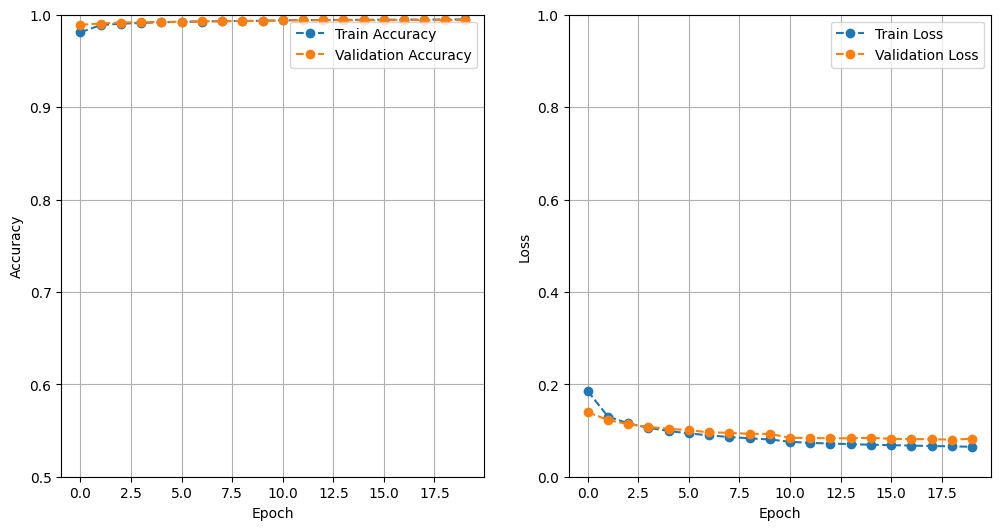

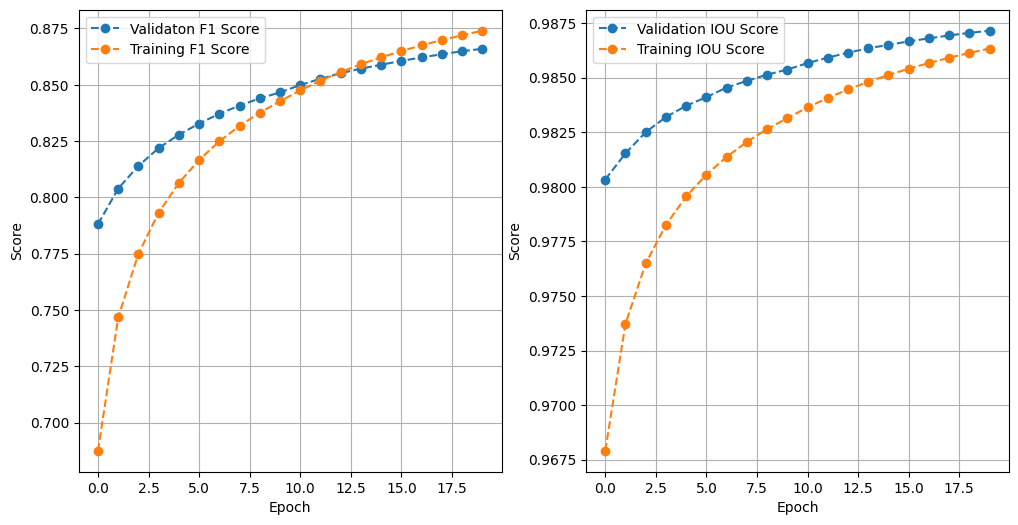

In [ ]:
# %%

if model_training:
    train(
        model,
        images_augmented,
        labels_augmented,
        images_validation,
        labels_validation,
        loss_func=BCEIoULoss(),
        batch_size=4,
        learning_rate=2e-4,
        epochs=20,
        model_validation=model_validation,
        cuda_available=cuda_available,
        path_model=path_model,
    )

if model_loading:
    # Load the model from your Google Drive or local file system
    checkpoint = torch.load(path_model)
    model.load_state_dict(checkpoint["model_state_dict"])

In [ ]:
# %%

submission = submission_creating(
    model, path_testing, training_resize, testing_resize, cuda_available
)

100%|██████████| 5/5 [00:01<00:00,  2.86it/s]


In [ ]:
# %%

np.savetxt("submit.csv", submission, delimiter=",", fmt="%s")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1218894].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0033040235..1.0847623].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0004824306..1.075873].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1066992].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0760508].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.3341668].


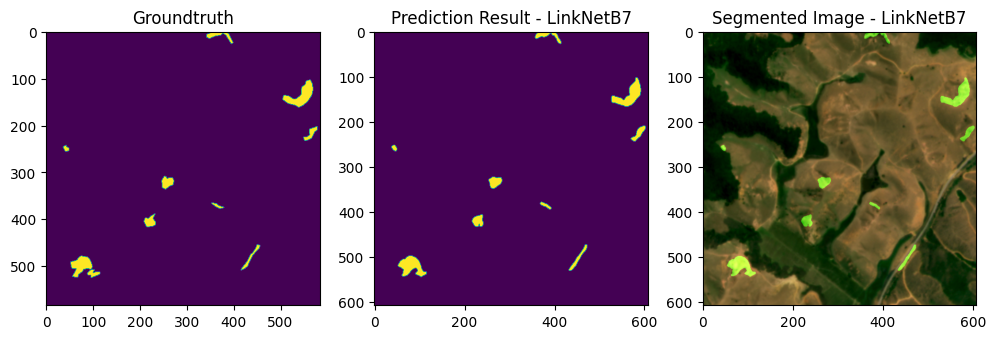

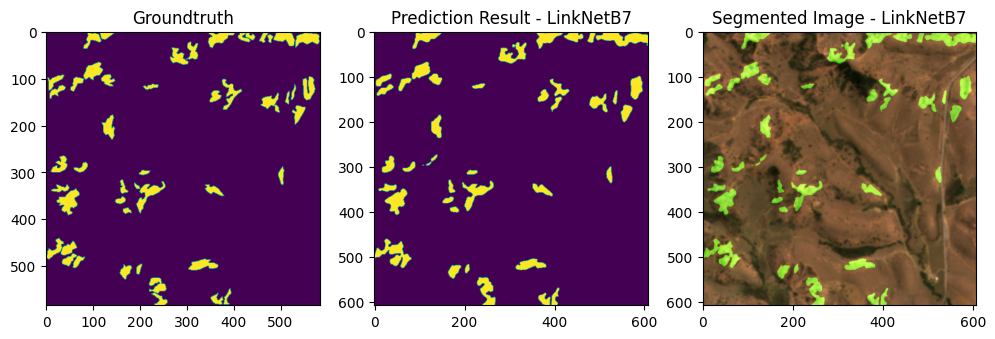

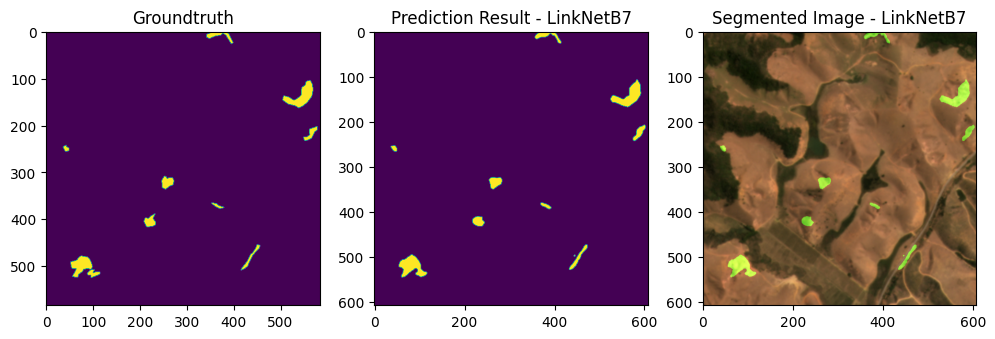

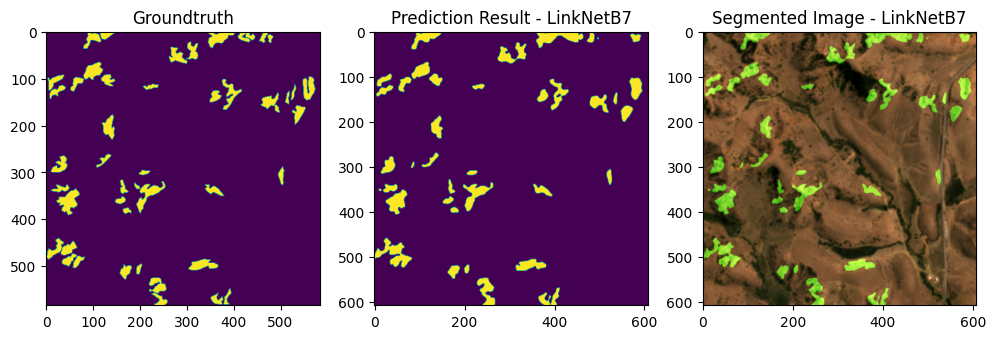

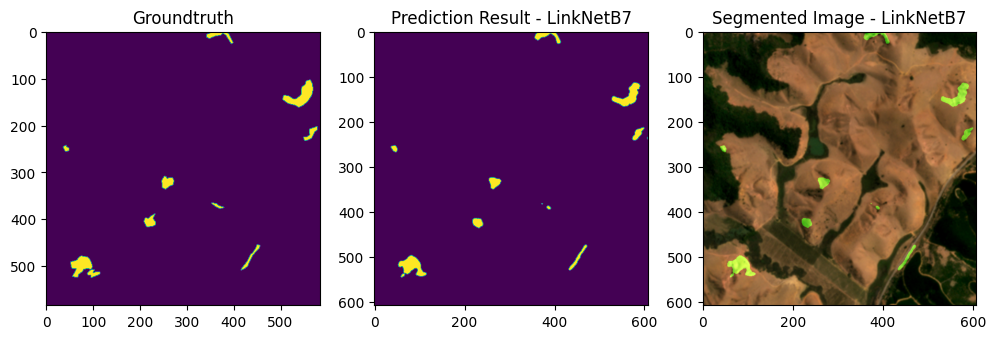

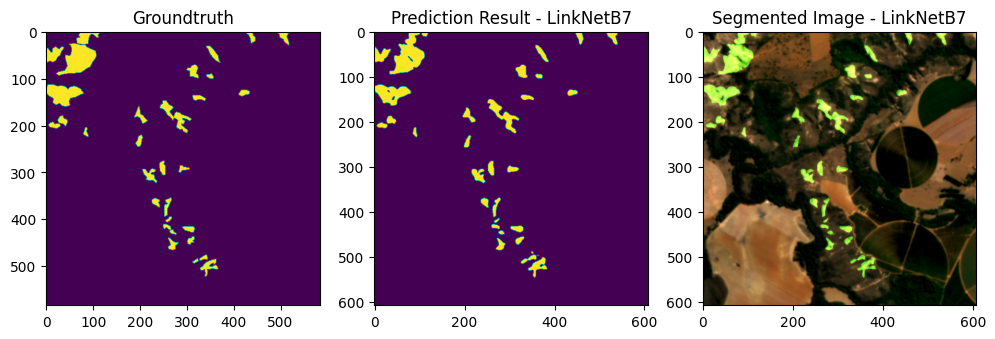

In [ ]:
# %%

for aux in range(747, 753):
    test(path_testing, aux, model, cuda_available)